(stan-reglin1-notebook)=
# Regressione multipla con Stan

## Preparazione del Notebook

In [1]:
%run ../_config/config.py # Import the configuration settings
import logging

import cmdstanpy

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
from cmdstanpy import CmdStanModel
from scipy import stats
import pingouin as pg

In [2]:
X = df[["weight", "age", "male"]]
y = df["height"]
# Perform linear regression using pingouin
lm = pg.linear_regression(X, y)

# Round the results to 2 decimal places
print(lm.round(2))


NameError: name 'df' is not defined

## Regressione multipla

La regressione multipla rappresenta un'estensione del modello di regressione semplice, e permette di esplorare e quantificare le relazioni tra una variabile dipendente e più variabili indipendenti. Passando dal modello semplice $ y = a + bx + \text{errore} $ al modello più generale $ y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \text{errore} $, emergono nuove complessità. Queste includono le decisioni su quali predittori $ x $ includere nel modello, l'interpretazione dei coefficienti e delle loro interazioni, e la costruzione di nuovi predittori a partire dalle variabili esistenti per catturare elementi di discrezionalità e non linearità. 

I coefficienti di regressione, in un contesto di regressione multipla, sono tipicamente più complicati da interpretare rispetto a quelli di un modello con un solo predittore. L'interpretazione di un dato coefficiente, infatti, è parzialmente condizionata dalle altre variabili presenti nel modello. Il coefficiente $ \beta_k $ rappresenta la differenza media o attesa nella variabile risposta $ y $, confrontando due individui che differiscono di un'unità nel predittore $ x_k $ ma sono identici per quanto riguarda gli altri predittori. Questo concetto è talvolta sintetizzato con l'espressione "confrontare due osservazionni (o persone) che differiscono per $ x_k $ a parità delle altre variabili".

Dal punto di vista dell'implementazione con Stan, l'estensione del modello per includere molteplici predittori dell'intelligenza del bambino è relativamente semplice. È necessario costruire una matrice $X$ contenente le colonne che rappresentano i vari predittori che intendiamo analizzare. Per l'esempio specifico in questione, i predittori selezionati per l'intelligenza del bambino includono: la scolarità della madre (codificata come 0 o 1 a seconda che la madre abbia completato o meno le scuole superiori), l'intelligenza della madre e l'età della madre. Prima di procedere con l'analisi, è importante standardizzare tutte queste variabili per facilitare l'interpretazione dei risultati e migliorare la stabilità numerica del modello.

Consideriamo in dettaglio la verosimiglianza `alpha + X * beta` nel caso in cui $X$ è una matrice con più di un predittore.

Prima di tutto, definiamo le variabili coinvolte:

- `y`: è il vettore delle osservazioni, dove ogni elemento rappresenta un dato osservato.
- `alpha`: è l'intercetta del modello lineare, un singolo valore che rappresenta il punto in cui la linea del modello incrocia l'asse y quando tutte le variabili indipendenti (`X`) sono zero.
- `X`: è la matrice dei predittori (o variabili indipendenti), dove ogni riga corrisponde a un'osservazione e ogni colonna a una variabile indipendente.
- `beta`: è il vettore dei coefficienti, dove ogni elemento rappresenta l'effetto di una corrispondente variabile indipendente in `X` sulla variabile dipendente `y`.
- `sigma`: è la deviazione standard degli errori del modello, che misura quanto i dati reali si discostano dalla linea del modello.

L'espressione `alpha + X * beta` calcola i valori previsti (`y` predetti) per il modello lineare. Ecco come funziona, spiegato senza ricorrere all'algebra matriciale:

1. **Moltiplicazione `X * beta`**: Per ogni riga in `X` (che rappresenta un'osservazione con le sue variabili indipendenti), moltiplichiamo ogni elemento (ogni variabile indipendente) per il corrispondente elemento in `beta` (il coefficiente della variabile) e sommiamo questi prodotti. Questo ci dà un valore singolo per ogni osservazione, che rappresenta il contributo combinato di tutte le variabili indipendenti alla variabile dipendente, prima di aggiungere l'intercetta.

2. **Aggiunta di `alpha`**: Dopo aver calcolato il contributo combinato delle variabili indipendenti, aggiungiamo l'intercetta (`alpha`) a questo valore. L'intercetta rappresenta il valore di `y` quando tutte le variabili indipendenti sono zero. Aggiungendola, otteniamo il valore previsto finale per `y` per ogni osservazione.

3. **Risultato**: L'espressione `alpha + X * beta` produce quindi un vettore di valori previsti di dimensione $n \times 1$, dove $n$ è il numero di osservazioni in `y`. Ogni elemento di questo vettore è il valore previsto di `y` per ogni osservazione, dato il modello lineare specificato.

Per fare un esempio semplice, immaginiamo di avere un modello con una sola variabile indipendente per semplificare:

- Supponiamo che `alpha` sia 5 (l'intercetta).
- La matrice `X` ha una sola colonna (una sola variabile indipendente) con, per esempio, tre osservazioni: `[1, 2, 3]`.
- Il vettore `beta` ha un solo elemento, diciamo 2, che è il coefficiente della nostra variabile indipendente.

Per ogni osservazione in `X`, moltiplichiamo il suo valore per `beta` (2 in questo caso) e aggiungiamo `alpha` (5). Quindi, per la prima osservazione (1), otteniamo $1 \times 2 + 5 = 7$, e così via per le altre osservazioni. Il risultato finale è un vettore di valori previsti di `y`.


Espandiamo ora l'esempio precedente per un caso di regressione multipla, dove abbiamo due variabili indipendenti (predittori). Questo ci permetterà di vedere come il processo di calcolo dei valori previsti si adatta quando ci sono più predittori nel modello.

- `alpha`: l'intercetta del modello, diciamo che è 5.
- `X`: la matrice dei predittori ora ha due colonne, perché abbiamo due variabili indipendenti. Per esempio, possiamo avere tre osservazioni come segue:

  $$
  X = \begin{bmatrix}
  1 & 3 \\
  2 & 2 \\
  3 & 1 \\
  \end{bmatrix}
  $$

  Qui, ogni riga rappresenta un'osservazione e ogni colonna rappresenta una variabile indipendente. Ad esempio, la prima riga rappresenta una osservazione dove il primo predittore ha valore 1 e il secondo predittore ha valore 3.

- `beta`: il vettore dei coefficienti ora ha due elementi, uno per ogni variabile indipendente. Supponiamo che `beta = [2, 1]`, dove 2 è il coefficiente per il primo predittore e 1 è il coefficiente per il secondo predittore.
- `sigma`: la deviazione standard degli errori del modello, che per semplicità non utilizzeremo direttamente in questo esempio.

Per calcolare i valori previsti (`y` predetti) per ogni osservazione, seguiamo questi passi:

1. **Moltiplicazione `X * beta`**:

   - Per la prima osservazione (`[1, 3]`), calcoliamo: $1 \times 2 + 3 \times 1 = 2 + 3 = 5$.
   - Per la seconda osservazione (`[2, 2]`), calcoliamo: $2 \times 2 + 2 \times 1 = 4 + 2 = 6$.
   - Per la terza osservazione (`[3, 1]`), calcoliamo: $3 \times 2 + 1 \times 1 = 6 + 1 = 7$.

   Questo passo ci dà il contributo combinato delle variabili indipendenti alla variabile dipendente per ogni osservazione.

2. **Aggiunta di `alpha`**:

   - Aggiungiamo l'intercetta `alpha` (5) ai risultati precedenti per ottenere i valori previsti finali di `y`:

     - Prima osservazione: $5 + 5 = 10$.
     - Seconda osservazione: $6 + 5 = 11$.
     - Terza osservazione: $7 + 5 = 12$.

3. **Risultato**:

   Otteniamo quindi un vettore di valori previsti di `y` di dimensione $n \times 1$, dove $n$ è il numero di osservazioni. In questo caso, il vettore dei valori previsti di `y` sarà `[10, 11, 12]`.

Questo esempio illustra come l'espressione `alpha + X * beta` in un contesto di regressione multipla produca un vettore di valori previsti. Ogni valore previsto è il risultato della somma del prodotto dei predittori per i loro rispettivi coefficienti più l'intercetta, riflettendo come il modello lineare stima `y` in base ai valori di più variabili indipendenti.

## Un esempio pratico

Per fare un esempio pratico, analizzeremo nuovamente i dati sull'intelligenza di un gruppo di bambini. In questo caso, cercheremo di predire l'intelligenza media dei bambini considerando tre fattori: se le madri hanno completato la scuola superiore, l'intelligenza della madre e l'età della madre.

Importiamo i dati:

In [ ]:
kidiq = pd.read_stata("../data/kidiq.dta")
kidiq.head()

Stampiamo il modello Stan di regressione multipla per questi dati. Il modello assume che i dati siano standardizzati.

In [4]:
stan_file = os.path.join('stan', 'linear_regression.stan')
with open(stan_file, 'r') as f:
    print(f.read())

// run with 4 chains and 2k iters.
// all data should be scaled to mean 0 and std 1:
data {
  int<lower=1> N;   // number of observations
  int<lower=1> K;   // number of independent variables, including the intercept
  matrix[N, K] X;   // data matrix
  vector[N] y;      // dependent variable vector
}
parameters {
  real alpha;           // intercept
  vector[K] beta;       // coefficients for independent variables
  real<lower=0> sigma;  // model error
}
model {
  // priors
  alpha ~ student_t(3, 0, 2.5);
  beta ~ student_t(3, 0, 2.5);
  sigma ~ exponential(1);

  // likelihood
  y ~ normal(alpha + X * beta, sigma);
}
generated quantities {
  vector[N] log_lik; // Log-likelihood for each observation
  vector[N] y_rep;  // Posterior predictions for each observation

  for (n in 1:N) {
    log_lik[n] = normal_lpdf(y[n] | alpha + dot_product(X[n], beta), sigma);
    y_rep[n] = normal_rng(alpha + dot_product(X[n], beta), sigma);
  }
}



Compiliamo il modello.

In [5]:
model = CmdStanModel(stan_file=stan_file)

Standaridizziamo i predittori:

In [6]:
x1 = stats.zscore(kidiq["mom_hs"])
x2 = stats.zscore(kidiq["mom_iq"])
x3 = stats.zscore(kidiq["mom_age"])

In [7]:
df = pd.DataFrame({
    "one": [1] * len(x1),  # Crea una lista di 1 della stessa lunghezza di x1
    "x1": x1,
    "x2": x2,
    "x3": x3
})

df.head()

,one,x1,x2,x3
0,1,0.522233,1.409460,1.562029
1,1,0.522233,-0.710026,0.820727
2,1,0.522233,1.030732,1.562029
3,1,0.522233,-0.036733,0.820727
4,1,0.522233,-0.484177,1.562029


In [8]:
# Convert scaled DataFrame to numpy matrix
X = df.to_numpy()

In [9]:
# Verificare le dimensioni di X
print("Dimensioni di X:", X.shape)

Dimensioni di X: (434, 4)


Creiamo un dizionario con i dati nel formato atteso da Stan:

In [10]:
stan_data = {
    "N": X.shape[0],
    "K": X.shape[1],  # Nota: questa include anche la colonna dell'intercetta 
    "X": X,
    "y": stats.zscore(kidiq["kid_score"])  # Assumo che kid_score sia la variabile dipendente
}

Eseguiamo il campionamento MCMC:

In [11]:
fit2 = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

Esaminiamo le tracce dei parametri:

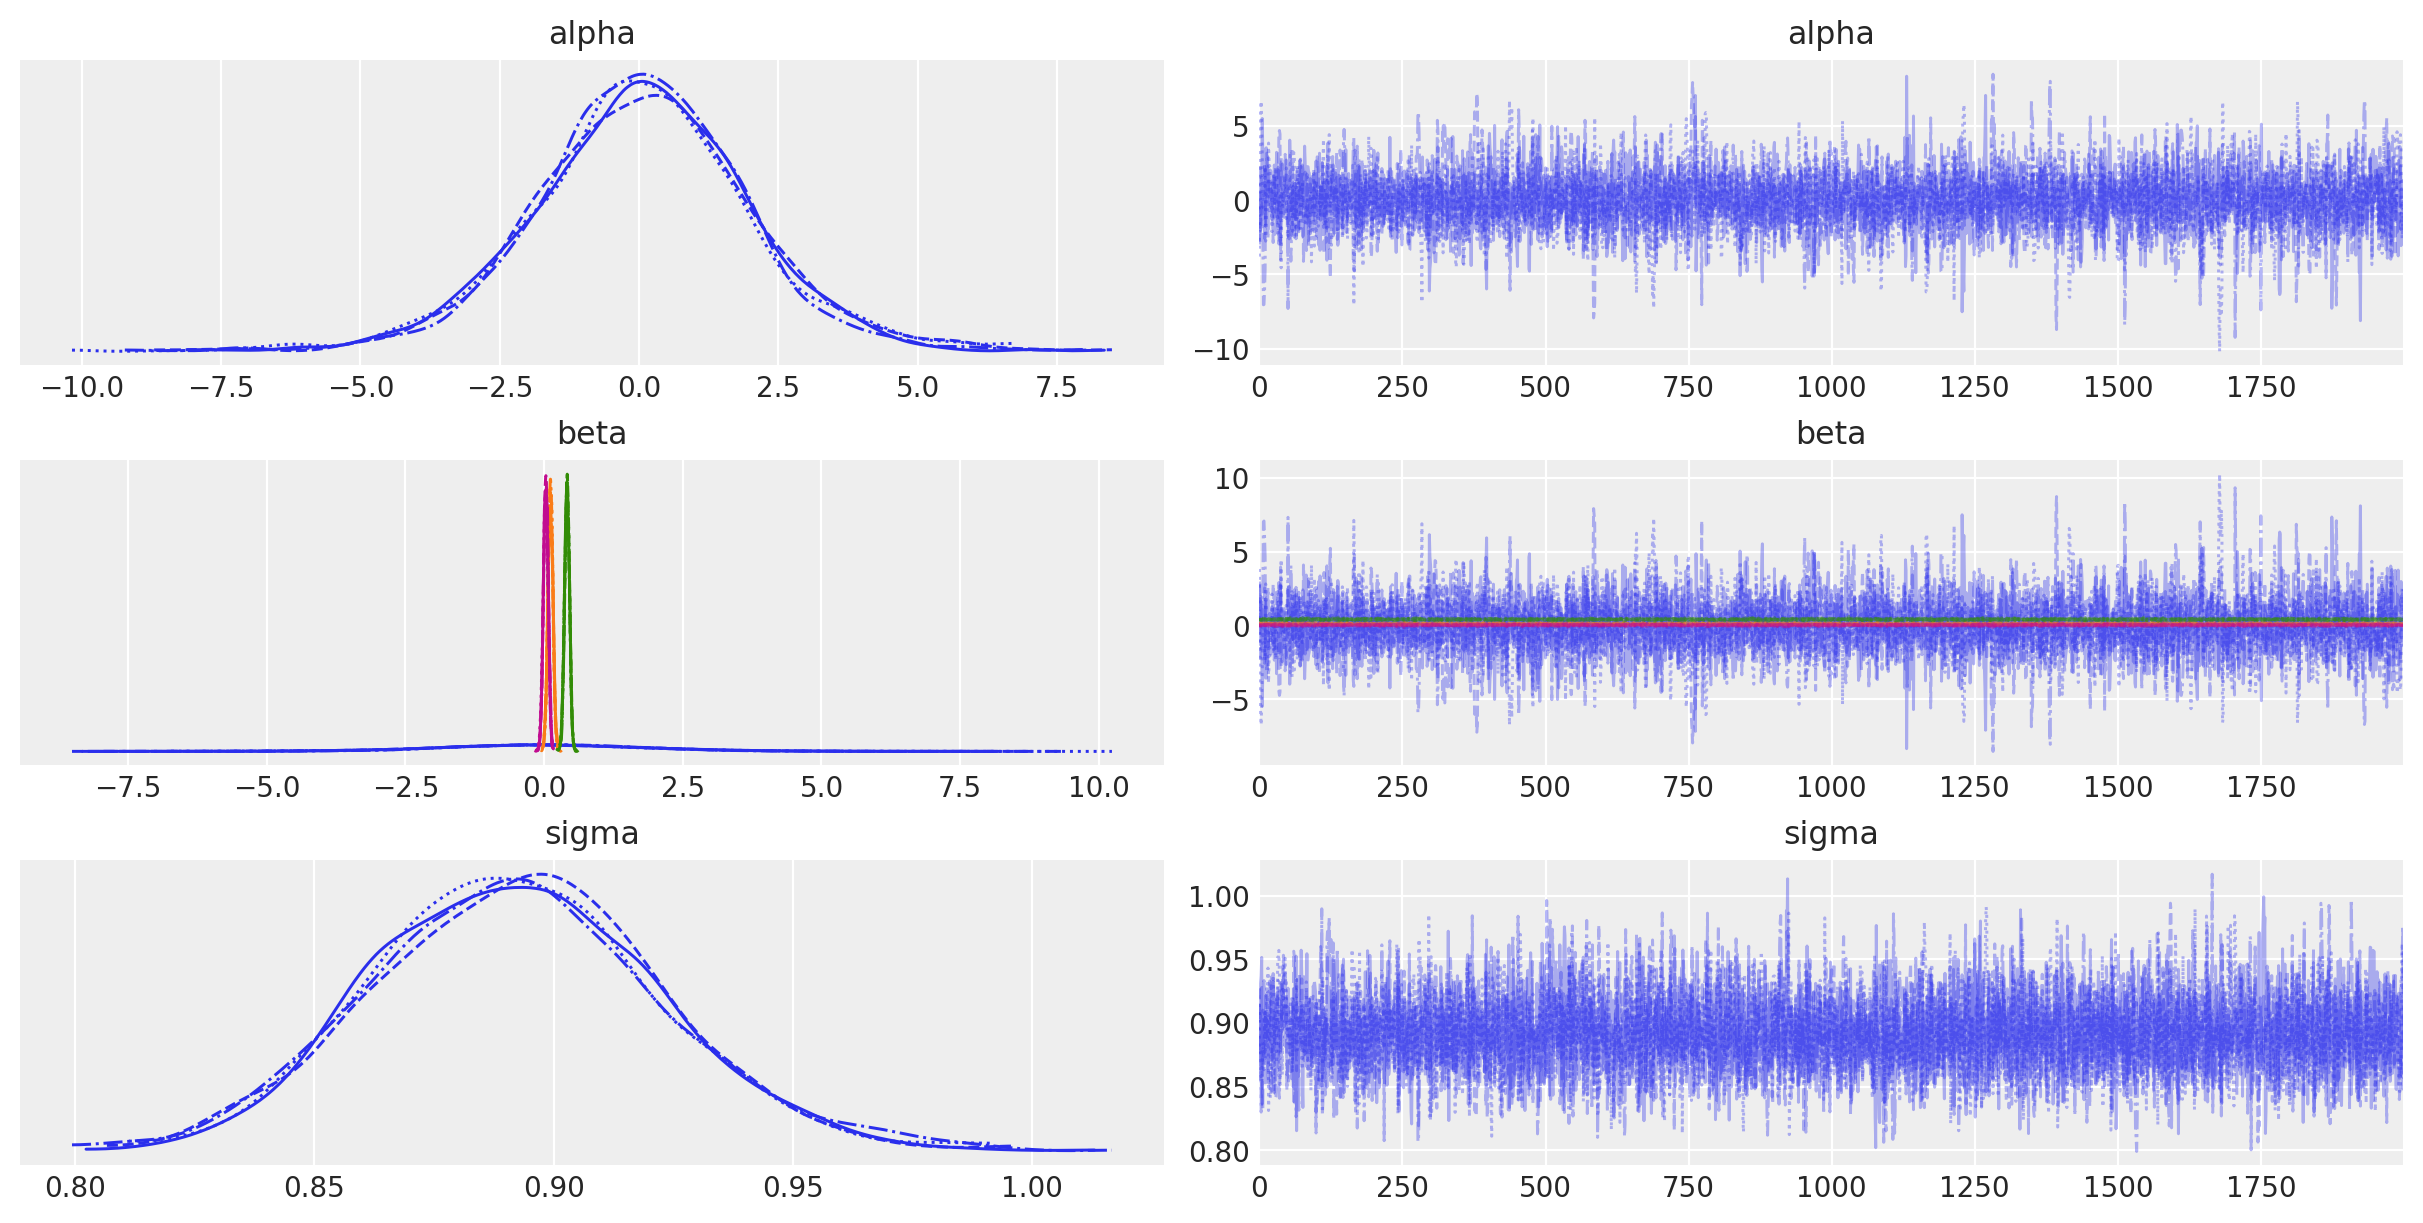

In [13]:
_ = az.plot_trace(fit2, var_names=(["alpha", "beta", "sigma"]))

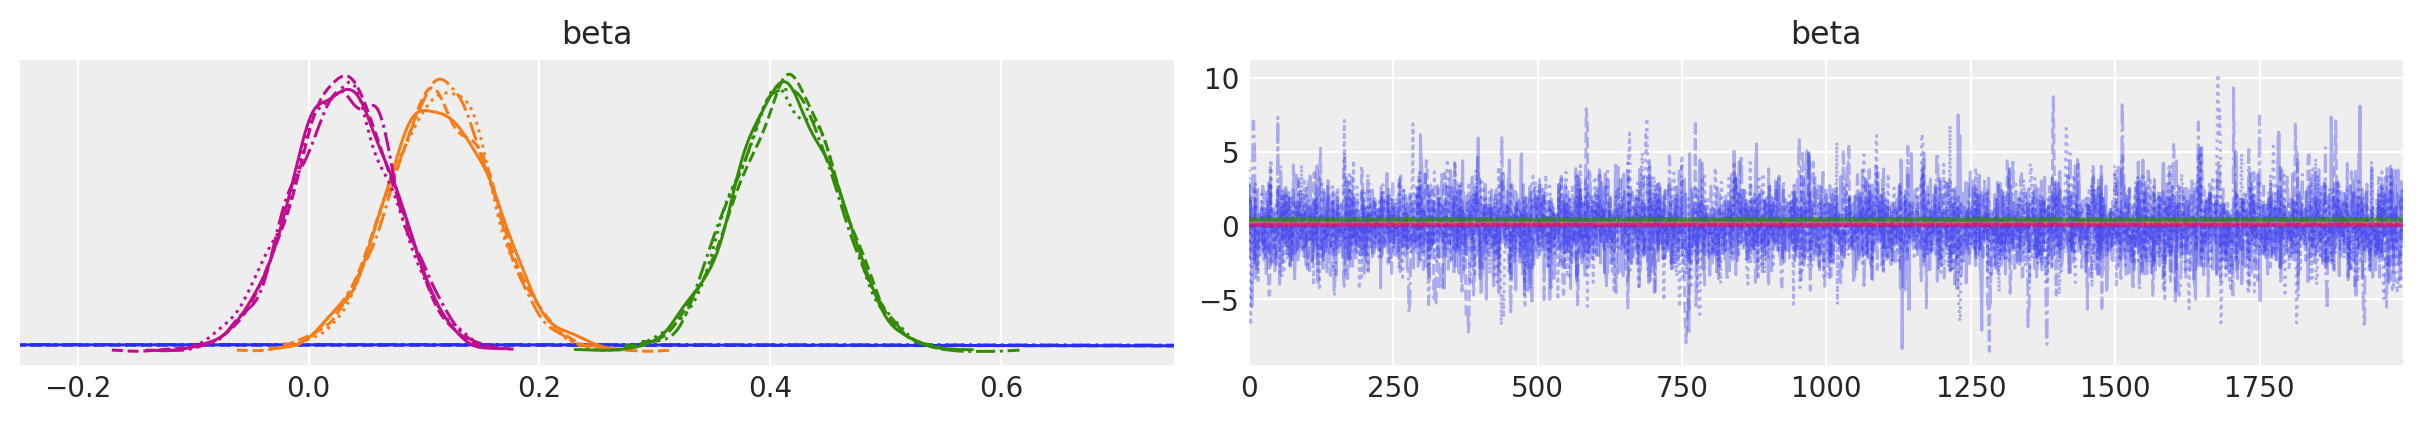

In [14]:
# Zoom in 
axes = az.plot_trace(fit2, var_names=["beta"])

for ax_row in axes:
    ax_row[0].set_xlim(-0.25, 0.75)  # Modifica solo l'asse del grafico della densità

plt.show()

Anche nel caso della regressione multipla, i risultati ottenuti con l'approccio bayesiano sono molto simili a quelli prodotti dall'approccio basato sulla massima verosimiglianza.

Calcoliamo una sintesi delle distribuzioni a posteriori dei parametri:

In [26]:
az.summary(fit2, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.020,1.958,-3.680,3.784,0.030,0.027,4412.0,2963.0,1.0
beta[0],-0.021,1.959,-3.652,3.794,0.030,0.027,4414.0,3080.0,1.0
beta[1],0.114,0.045,0.032,0.202,0.001,0.000,5939.0,5353.0,1.0
beta[2],0.413,0.044,0.325,0.489,0.001,0.000,7429.0,5414.0,1.0
beta[3],0.030,0.043,-0.053,0.109,0.001,0.000,7277.0,5658.0,1.0
sigma,0.892,0.030,0.836,0.949,0.000,0.000,6955.0,5019.0,1.0


Replichiamo il risultato usando l'approccio di massima verosimiglianza:

In [17]:
lm = pg.linear_regression(X, stats.zscore(kidiq["kid_score"]))
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.00,0.04,-0.00,1.00,0.21,0.21,-0.08,0.08
1,x2,0.11,0.05,2.50,0.01,0.21,0.21,0.02,0.20
2,x3,0.41,0.04,9.28,0.00,0.21,0.21,0.33,0.50
3,x4,0.03,0.04,0.68,0.50,0.21,0.21,-0.06,0.12


Nel contesto della regressione multivariata, l'interpretazione dei coefficienti parziali differisce da quella della regressione bivariata. Nel nostro caso, il coefficiente associato all'intelligenza della madre, indicato come $\beta$ = 0.41, assume il seguente significato: prevediamo che l'intelligenza del bambino aumenti di 0.41 deviazioni standard in media per ogni deviazione standard aggiuntiva nell'intelligenza della madre, mantenendo costanti gli effetti del livello di istruzione e dell'età della madre. Questo implica che stiamo considerando l'impatto dell'intelligenza della madre sull'intelligenza del bambino all'interno di una popolazione di madri che sono omogenee per quanto riguarda il livello di istruzione e l'età.

Calcoliamo la distribuzione predittiva a posteriori e generiamo il PPC plot:

In [18]:
idata2 = az.from_cmdstanpy(
    posterior=fit2,
    posterior_predictive='y_rep',
    observed_data={'y': stats.zscore(kidiq["kid_score"])},
)

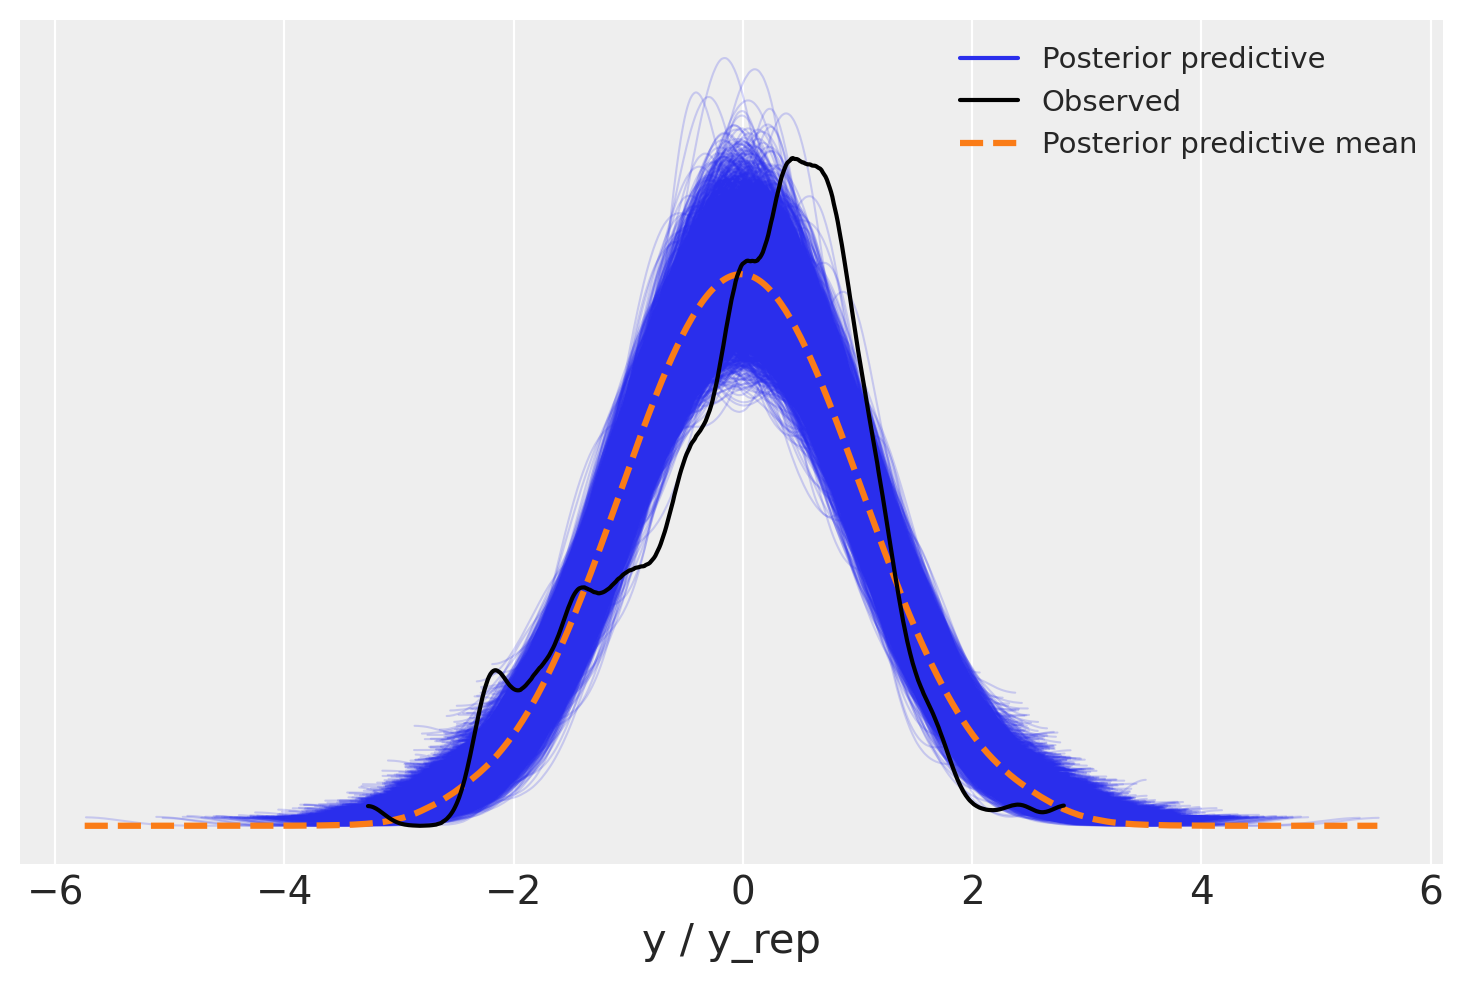

In [19]:
_ = az.plot_ppc(idata2, data_pairs={'y': 'y_rep'})

Per fare un esercizio, riscriviamo il modello senza usare l'algebra matriciale.

In [20]:
stan_file = os.path.join("stan", "mreg.stan")
with open(stan_file, "r") as f:
    print(f.read())

data {
    int<lower=1> N;   // Numero di osservazioni
    int<lower=1> K;   // Numero di variabili indipendenti, intercetta inclusa
    vector[N] x1;     // Prima variabile indipendente
    vector[N] x2;     // Seconda variabile indipendente
    vector[N] x3;     // Seconda variabile indipendente
    // Aggiungi altri vettori se ci sono più variabili indipendenti
    vector[N] y;      // Vettore della variabile dipendente
}
parameters {
    real alpha;           // Intercetta
    real beta1;           // Coefficiente per la prima variabile indipendente
    real beta2;           // Coefficiente per la seconda variabile indipendente
    real beta3;           // Coefficiente per la terza variabile indipendente
    // Definisci altri real per ulteriori coefficienti
    real<lower=0> sigma;  // Errore del modello
}
model {
    // Prior
    alpha ~ student_t(3, 0, 2.5);
    beta1 ~ student_t(3, 0, 2.5);
    beta2 ~ student_t(3, 0, 2.5);
    beta3 ~ student_t(3, 0, 2.5);
    // Definisci pri

Compiliamo il modello.

In [21]:
model3 = CmdStanModel(stan_file=stan_file)

Generiamo il dizionario con i dati nel formato appropriato per Stan.

In [22]:
stan_data = {
    "N": df.shape[0],
    "K": 4,  # Nota: questa include anche la colonna dell'intercetta
    "x1": x1,
    "x2": x2,
    "x3": x3,
    "y": stats.zscore(kidiq["kid_score"])
}

Eseguiamo il campionamento.

In [23]:
fit3 = model3.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

I risultati replicano quelli ottenuti in precedenza.

In [24]:
az.summary(
    fit3,
    var_names=(["alpha", "beta1", "beta2", "beta3", "sigma"]),
    hdi_prob=0.94
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.043,-0.077,0.084,0.0,0.0,8977.0,5942.0,1.0
beta1,0.114,0.046,0.026,0.198,0.0,0.0,9573.0,6486.0,1.0
beta2,0.413,0.044,0.334,0.499,0.0,0.0,9730.0,6090.0,1.0
beta3,0.030,0.044,-0.053,0.113,0.0,0.0,9154.0,6239.0,1.0
sigma,0.893,0.031,0.837,0.954,0.0,0.0,8242.0,5824.0,1.0


## Una nota di cautela sui modelli di regressione

Nel suo libro *Statistical Rethinking*, {cite:t}`McElreath_rethinking` introduce l'idea di modelli statistici paragonandoli ai Golem, antiche creature della mitologia, prive di volontà propria e animate solo dall'intento di chi le crea. Questi enti, pur essendo dotati di grande forza, possono diventare pericolosi se non guidati con saggezza.

{cite:t}`McElreath_rethinking` sostiene che gli scienziati, nella creazione di modelli matematici e software, diano vita a moderni equivalenti di questi Golem. Questi modelli, sebbene influenzino il mondo reale tramite le loro previsioni e le intuizioni che generano, non dovrebbero essere considerati né completamente veritieri né falsi. Essi sono piuttosto strumenti sviluppati con uno scopo specifico, capaci di operare calcoli con estrema precisione, ma privi della capacità di comprendere o interpretare il contesto più ampio in cui sono applicati.

In particolare, il modello di regressione viene esaminato come esempio di come tali strumenti possano produrre risultati concreti, ma manchino di adattabilità e giudizio autonomo, limitando la loro efficacia nel trattare questioni che richiedono un approccio più creativo e comprensivo. {cite:t}`McElreath_rethinking` enfatizza ulteriormente che nessun strumento statistico, da solo, è sufficiente per affrontare adeguatamente il complesso problema dell'inferenza causale a partire da dati empirici. Questi modelli, privi di una reale comprensione delle dinamiche di causa ed effetto, si limitano a descrivere relazioni tra variabili. Senza un'interpretazione critica e un orientamento consapevole da parte degli scienziati, questi strumenti, creati per fini ben definiti, possono rivelarsi non solo inefficaci, ma anche potenzialmente dannosi.

## Informazioni sull'Ambiente di Sviluppo

In [25]:
%load_ext watermark
%watermark -n -u -v -iv -w -m 

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas    : 2.2.2
matplotlib: 3.8.4
logging   : 0.5.1.2
numpy     : 1.26.4
cmdstanpy : 1.2.3
scipy     : 1.13.1
pingouin  : 0.5.4
arviz     : 0.18.0

Watermark: 2.4.3

